In [ ]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import datetime
from scipy.stats import norm
import statsmodels.formula.api as smf
import yfinance as yf
from tqdm import tqdm # Progress bar
import yfinance as yf

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive') # horrible

Mounted at /content/drive


In [ ]:
# Simple Kalman Filter || 1 Dimensional

def KalmanFilter(z, x0, P0, Q, R):
    '''
    z: nx1 vector of observations
    x0: initial guess of state
    P0: initial guess of error
    Q: process noise
    R: measurement noise
    '''
    # number of observations
    n = len(z)

    # allocate space for arrays
    xhat = np.zeros(n)      # a posteriori estimate of x
    P = np.zeros(n)         # a posteriori error estimate
    xhatminus = np.zeros(n) # a priori estimate of x
    Pminus = np.zeros(n)    # a priori error estimate
    K = np.zeros(n)         # Kalman gain

    # intial guesses
    xhat[0] = x0
    P[0] = P0

    for i in range (1, n):
        # Prediction Step
        xhatminus[i] = xhat[i-1]
        Pminus[i] = P[i-1] + Q

        # Measurement Update Step
        K[i] = Pminus[i] / (Pminus[i] + R)
        xhat[i] = xhatminus[i] + K[i] * (z[i] - xhatminus[i])
        P[i] = (1 - K[i]) * Pminus[i]

    return xhat, P

In [ ]:
# Apply strategy & compute returns
def apply_strategy(df, T):
    z = 1.645

    # Calculate surprise
    df['surprise'] = df['I_diff'] - df['filter_I']

    # Calculate E_bar
    df['E_bar'] = df['surprise'].expanding(T).mean()

    # Calculate mu_t
    df['mu_t'] = df['surprise'].rolling(T).mean()

    # Calculate std_t
    df['std_t'] = df['surprise'].rolling(T).std(ddof=1)

    # Create our T variable
    df['T'] = T

    # Calculate test_stat
    df['test_stat'] = df['mu_t'] / (df['std_t'] / np.sqrt(T))

    # Calculate signal
    df['signal'] = np.where((df['test_stat'] > -z) & (df['E_bar'] < 0), 1,
                    np.where((df['test_stat'] < z) & (df['E_bar'] > 0), -1, 0))

    df.dropna(inplace=True)

    # Calculate returns
    df['returns'] = np.log(df.GBPUSD).diff()

    # Strategy returns
    df['strat_ret'] = df.signal.shift(1) * df.returns

    # Cumulative returns
    df['cum_ret'] = df.strat_ret.cumsum()

    # Convert to simple returns
    df['cum_ret_simple'] = np.exp(df.cum_ret) - 1

    return df

In [ ]:
# Load data
file1 = '/content/drive/MyDrive/ECON 409 Project/Sample Data/final_project_data.csv'
data = pd.read_csv(file1, parse_dates=True, index_col=0)

# Rename Columns
## I_US : US Interest Rate
## I_UK : UK Interest Rate
## pi_UK : UK Inflation Rate
## pi_US : US Inflation Rate
## prod_US : US Industrial Production
## prod_UK : UK Industrial Production
data.columns = ['I_US', 'I_UK', 'pi_UK', 'pi_US', 'prod_US', 'prod_UK']

# Calculate the interest rate differential
data['I_diff'] = data['I_UK'] - data['I_US']

I_diff = data['I_diff']

I_diff.dropna(inplace=True)

In [ ]:
# Yahoo Finance Data
exrate = yf.download('GBPUSD=X')[["Open"]].copy()
exrate.columns = ["GBPUSD"]

# Merge data
#data_merged = pd.merge(I_diff, exrate, left_index=True, right_index=True, how='inner')
data_merged = pd.merge_asof(I_diff, exrate, left_index=True, right_index=True, direction='backward')

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Simple Dataframe
data_kf = data_merged.copy()
data_kf = data_kf[['I_diff', 'GBPUSD']]
data_kf = data_kf.dropna()

In [ ]:
data_kf

,I_diff,GBPUSD
Date,,
2003-12-01,2.515,1.723811
2003-12-02,2.550,1.719010
2003-12-03,2.491,1.730493
2003-12-04,2.497,1.727414
2003-12-05,2.575,1.720608
...,...,...
2023-12-21,-0.304,1.264063
2023-12-22,-0.294,1.268617
2023-12-27,-0.289,1.272831


# Strategy ("409 Strategy" from Week 2 Lab)

The Null hypothesis of the test is that the current mean is different from the sample mean. Therefore if we fail to reject the null hypothesis, then we expect the direction to change.

There are two cases

1. The sample mean, $\bar{\varepsilon}_i$, up to observation $i$ is negative, i.e., $\bar{\varepsilon}_i < 0$.

2. $\bar{\varepsilon}_i > 0$

- For case (1): If we fail to reject the null ($\hat{\mu}_t > 0$) then we assume the current mean of the IRD is positive. Thus, we go long.

- For case (2): If we fail to reject the null ($\hat{\mu}_t < 0$) then we assume the current mean of the IRD is negative. Thus, we go short.

In [ ]:
# Training Set
## Tune the hyperparameters: Q, R, & T
## Optimize for highest training Sharpe Ratio

# Segment Data into training and deployment sets
# Training (2004 - 2013)
# Deployment (2014 - 2024)
train = data_kf.loc[:"2019"]
deploy = data_kf.loc["2020":]

# Define Critical Value
z = 1.645

# Assumed Filter Parameters
x0 = 0 # Initial state guess
P0 = 1 # Initial covariance estimate

# Define the grid
Q_values = np.linspace(0.001, 0.1, 25)
R_values = np.linspace(0.01, 0.5, 25)
T_values = np.arange(5, 30, 5)

# Create a dataframe to store the results
results = pd.DataFrame(columns=['Q', 'R', 'T', 'CCROR', 'AR', 'SR'])

# Loop through the grid
for Q in tqdm(Q_values):
    for R in R_values:
        for T in T_values:
            # Training Data
            train = data_kf.loc[:"2013"]

            # Kalman Filter
            filter_train, P_train = KalmanFilter(train.I_diff.values, x0, P0, Q, R)

            # Store the results
            train = train.assign(filter_I=filter_train)

            # Strategy
            train = apply_strategy(train, T)

            # Metrics
            CCROR_train = np.log(train.cum_ret_simple[-1] + 1)/(len(train)/252)
            AR_train = (train.cum_ret_simple.iloc[-1] +1)**(252/len(train)) - 1
            r_f = (1 + 0.0147)**(1/252) - 1 ## NEW RISK FREE RATE TAKEN FROM HRFI
            excess_ret_train = train.strat_ret - r_f
            sr_train = np.sqrt(252) * (excess_ret_train.mean() / excess_ret_train.std())

            # Store the results
            results = results.append({'Q': Q, 'R': R, 'T': T, 'CCROR': CCROR_train,
                                       'AR': AR_train, 'SR': sr_train},
                                         ignore_index=True)

# Find the best parameters
best_params = results.loc[results.SR.idxmax()]
best_params

100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


Q        0.046375
R        0.173333
T        5.000000
CCROR    0.104864
AR       0.110559
SR       1.005086
Name: 1415, dtype: float64

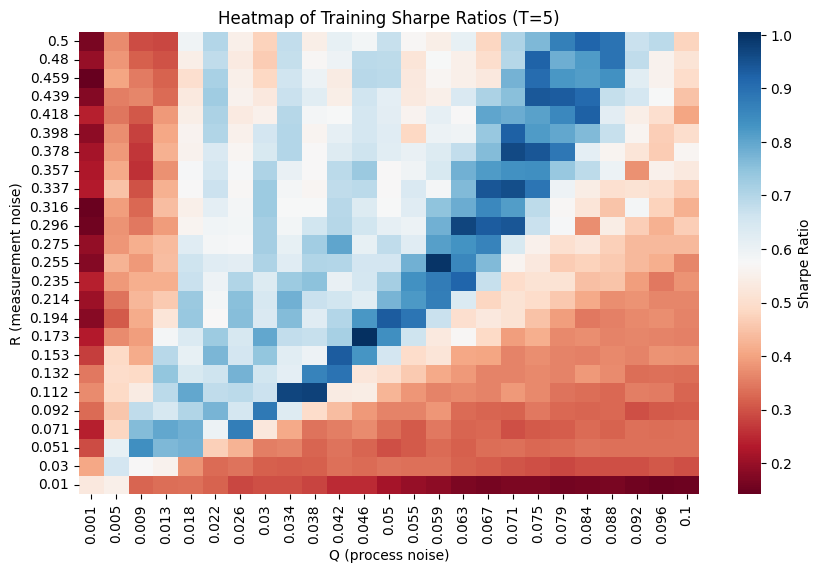

In [ ]:
# Heatmap of sharp ratios
## Fix T = 5
results_T5 = results[results['T']== 5]
results_T5_pivot = results_T5.pivot('R', 'Q', 'SR')

plt.figure(figsize=(10, 6))
sns.heatmap(results_T5_pivot, cmap='RdBu', cbar_kws={'label': 'Sharpe Ratio'})

# Round x-axis labels
plt.xticks(np.arange(len(results_T5_pivot.columns)) + 0.5, np.round(results_T5_pivot.columns, 3), rotation=90)

# Round y-axis labels
plt.yticks(np.arange(len(results_T5_pivot.index)) + 0.5, np.round(results_T5_pivot.index, 3), rotation=0)

# flip y axis
plt.gca().invert_yaxis()

plt.title('Heatmap of Training Sharpe Ratios (T=5)')
plt.xlabel('Q (process noise)')
plt.ylabel('R (measurement noise)')
plt.show()

In [ ]:
# Use the best parameters to calculate the deployment set
Q = best_params['Q']
R = best_params['R']
T = best_params['T'].astype(int)

# Data
deploy = data_kf.loc["2020":]

# Kalman Filter
filter_deploy, _ = KalmanFilter(deploy.I_diff.values, x0, P0, Q, R)

# Store the results
deploy = deploy.assign(filter_I=filter_deploy)

# Strategy
deploy = apply_strategy(deploy, T)

# Calculate returns
deploy['returns'] = np.log(deploy.GBPUSD).diff()

# Strategy returns
deploy['strat_ret'] = deploy.signal.shift(1) * deploy.returns

# Cumulative Returns
deploy['cum_ret'] = deploy.strat_ret.cumsum()

# Convert to simple returns
deploy['cum_ret_simple'] = np.exp(deploy.cum_ret) - 1

# Metrics
CCROR_deploy = np.log(deploy.cum_ret_simple.iloc[-1] + 1)/(len(deploy)/252)
AR_deploy = (deploy.cum_ret_simple.iloc[-1] +1)**(252/len(deploy)) - 1
r_f = (1 + 0.0147)**(1/252) - 1  ## NEW RISK FREE RATE TAKEN FROM HRFI
excess_ret_deploy = deploy.strat_ret - r_f
sr_deploy = np.sqrt(252) * (excess_ret_deploy.mean() / excess_ret_deploy.std())

print('CCROR (deploy): {:.2%}'.format(CCROR_deploy))
print('AR (deploy): {:.2%}'.format(AR_deploy))
print('Sharpe Ratio (deploy): {:.3f}'.format(sr_deploy))

CCROR (deploy): 2.93%
AR (deploy): 2.98%
Sharpe Ratio (deploy): 0.167


In [ ]:
# Final Equity
deploy['cum_ret'].tail()

Date
2023-12-21    0.113266
2023-12-22    0.113266
2023-12-27    0.113266
2023-12-28    0.113266
2023-12-29    0.113266
Name: cum_ret, dtype: float64

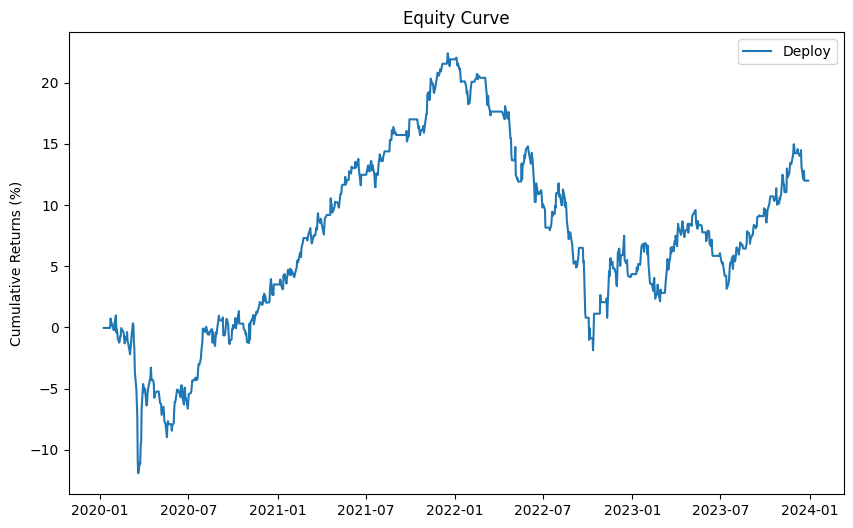

In [ ]:
# Plot equity curves
plt.figure(figsize=(10, 6))
plt.plot(deploy.cum_ret_simple*100, label="Deploy")
plt.title("Equity Curve")
plt.ylabel("Cumulative Returns (%)")
plt.legend()
plt.show()

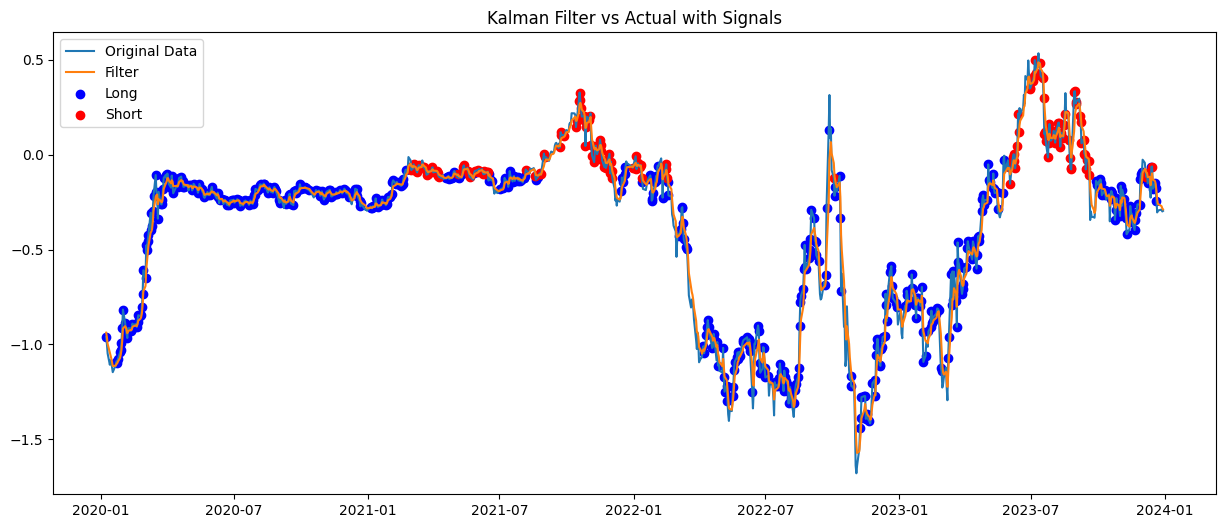

In [ ]:
# Plot deployment data vs filter with signals
plt.figure(figsize=(15, 6))
plt.plot(deploy.index, deploy.I_diff, label="Original Data")
plt.plot(deploy.index, deploy.filter_I, label="Filter")
plt.scatter(deploy.index[deploy.signal == 1], deploy.I_diff[deploy.signal == 1], color='blue', marker='o', label='Long')
plt.scatter(deploy.index[deploy.signal == -1], deploy.I_diff[deploy.signal == -1], color='red', marker='o', label='Short')
plt.title("Kalman Filter vs Actual with Signals")
plt.legend()
plt.show()

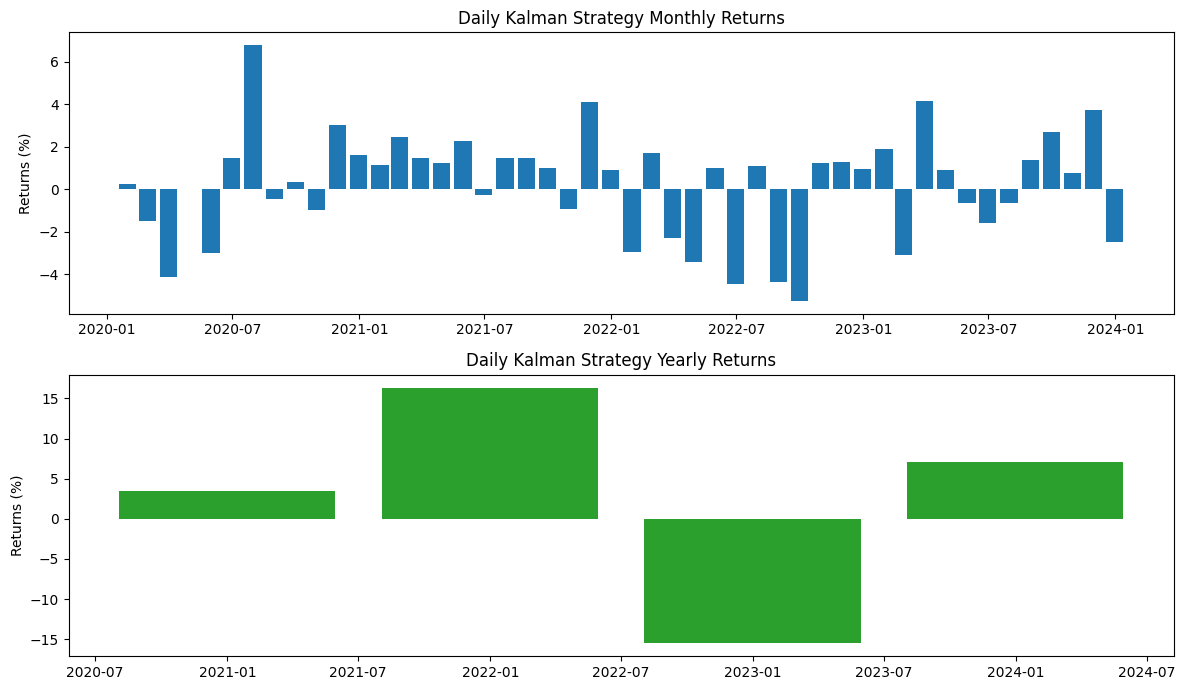

In [ ]:
# Monthly & Year Returns
mrets = deploy.strat_ret.resample('M').sum()
yrets = deploy.strat_ret.resample('Y').sum()

# Plot Returns
fig, ax = plt.subplots(2, 1, figsize=(12,7))

## Monthly
ax[0].bar(mrets.index, mrets*100, color='C0', width=25)
ax[0].set_title('Daily Kalman Strategy Monthly Returns')
ax[0].set_ylabel('Returns (%)')

## Yearly
ax[1].bar(yrets.index, yrets*100, color='C2', width=300)
ax[1].set_title('Daily Kalman Strategy Yearly Returns')
ax[1].set_ylabel('Returns (%)')

plt.tight_layout()
plt.show()

## Directional Tests

### Binomial Test

In [ ]:
# Binomial Test
# Test Data Frame
test_frame = deploy.copy()

test_frame = test_frame[test_frame.signal != 0][['signal', 'GBPUSD']].copy()
test_frame['D'] = test_frame['signal']

# Exchange Rate
test_frame['s_current'] = test_frame['GBPUSD']
test_frame['s_future'] = test_frame['GBPUSD'].shift(-1)

# Realized Exchange Rate
test_frame['R'] = np.where(
    test_frame['s_future'] >= test_frame['s_current'], 1, -1)

In [ ]:
# Sample Covariance
test_frame['W'] = (test_frame['D']- np.mean(
    test_frame['D'])) * (test_frame['R'] - np.mean(
        test_frame['R']))
T_B = np.mean(test_frame['W'])

print('Sample Covariance: ', T_B)

Sample Covariance:  0.05049619416360831


In [ ]:
# Newey-West LRV Estimator
dy = test_frame['W'] - np.mean(test_frame['W'])
gamma_0 = sum((dy)**2)/len(test_frame)
gamma_1 = np.mean((dy*dy.shift(-1))[:len(test_frame)-1])
LRV = gamma_0 + 2*(1-1/2)*gamma_1

# Test Statistic
statistic = T_B / np.sqrt(LRV/test_frame.shape[0])
print('Test Stastistic: ', statistic)
print('5% Critical Value: ', norm.ppf(0.95))

Test Stastistic:  1.68222222561622
5% Critical Value:  1.6448536269514722


Under the Binomial Test, the test statistic is less than the critical value, therefore we **reject** the null. Hence, we can reject the hypothesis that our directional forecasts are uncorrelated with the realized directional changes. This suggests that our directional forecasts may be successfully capturing the realized appreciation or depreciation of exchange rates.

### Weighted Binomial Test

In [ ]:
# Weighted Binomal Test
## Weighted Mean
test_frame['W_2'] = test_frame['D']*(
    test_frame['s_future'] - test_frame['s_current'])
T_WB = np.mean(test_frame['W_2'])

print('T_WB: ', T_WB)

T_WB:  0.00016028827869409964


In [ ]:
## Newey-West LRV Estimator
dy_2 = test_frame['W_2'] - np.mean(test_frame['W_2'])
gamma_0 = ((dy_2)**2).sum()/len(test_frame)
gamma_1 = np.mean((dy_2*dy_2.shift(-1))[:len(test_frame)-1])
LRV_2 = gamma_0 + 2*(1-1/2)*gamma_1

## Test Statistic
statistic_2 = T_WB / np.sqrt(LRV_2/len(test_frame))
print('Test Stastistic: ', statistic_2)
print('5% Critical Value: ', norm.ppf(0.95))

Test Stastistic:  0.47703025354793516
5% Critical Value:  1.6448536269514722


Under the Weighted Binomial Test, the test statistic is  less than that of the critica value. Regardless, we **fail to reject** the null hypothesis. Therefore, the expected value of our weigvhted directional forecasts is statistically insignificantly different from 0. This suggests that our directional forecarts are not capturing the big movements of the realized appreciation or depreciation of exchange rates.

So we fail to reject the null under both tests. From this, we conclude that our model is not doing a great job capturing the movements in the exchange rates.

# Metrics

In [ ]:
# Resample Data to Monthly
M_data = deploy.resample('M').sum()
M_data.head()

,I_diff,GBPUSD,filter_I,surprise,E_bar,mu_t,std_t,T,test_stat,signal,returns,strat_ret,cum_ret,cum_ret_simple
Date,,,,,,,,,,,,,,
2020-01-31,-17.722,22.203497,-17.733410,0.011410,-2.166230,-0.438724,0.740818,85,-21.462059,9,-0.001912,0.002638,0.008382,0.008432
2020-02-29,-16.546,24.639316,-16.837570,0.291570,-0.746294,0.292778,0.399707,95,33.845364,19,-0.015169,-0.015169,-0.122549,-0.121884
2020-03-31,-6.419,27.242702,-7.288398,0.869398,-0.158467,0.939544,0.880423,110,57.320869,22,-0.041482,-0.041482,-1.176680,-1.127226
2020-04-30,-3.028,24.812496,-2.981336,-0.046664,-0.017791,0.037485,0.330167,100,1.040235,16,0.008344,0.000247,-1.032806,-1.006030
2020-05-31,-3.583,23.386198,-3.527208,-0.055792,-0.024581,-0.068489,0.206079,95,-15.414339,17,-0.012059,-0.029856,-1.462867,-1.407123


In [ ]:
# Geometric Average Monthly

## Geometric mean (in this function) requires returns to be simple returns
## Current 'strat_ret' is log returns, so must convert first
def geo_mean(value):
  return (value + 1).prod() ** (1 / len(value)) - 1

geo_mean(np.exp(M_data['strat_ret'])-1)

0.0023624997977382822

In [ ]:
# This was what you originally had
## turns out, doesn't really make that much of a difference here lol
geo_mean(M_data['strat_ret'])

0.0020525291453872274

In [ ]:
# Standard Deviation        # Nathan's code had an error here and was just duplicated for both this and annualized so I think it's correct
M_data['strat_ret'].std()

0.02503113953398762

In [ ]:
# High/Low Months
M_data['strat_ret'].sort_values()

Date
2022-09-30   -0.052674
2022-06-30   -0.044590
2022-08-31   -0.043829
2020-03-31   -0.041482
2022-04-30   -0.034371
2023-02-28   -0.031105
2020-05-31   -0.029856
2022-01-31   -0.029526
2023-12-31   -0.024860
2022-03-31   -0.023210
2023-06-30   -0.015912
2020-02-29   -0.015169
2020-10-31   -0.009984
2021-10-31   -0.009464
2023-05-31   -0.006531
2023-07-31   -0.006420
2020-08-31   -0.004772
2021-06-30   -0.002605
2020-04-30    0.000247
2020-01-31    0.002638
2020-09-30    0.003352
2023-10-31    0.007786
2023-04-30    0.009109
2021-12-31    0.009221
2022-12-31    0.009396
2021-09-30    0.009993
2022-05-31    0.010015
2022-07-31    0.010931
2021-01-31    0.011247
2021-04-30    0.012283
2022-10-31    0.012546
2022-11-30    0.012830
2023-08-31    0.013695
2021-03-31    0.014551
2021-08-31    0.014722
2021-07-31    0.014763
2020-06-30    0.014930
2020-12-31    0.016355
2022-02-28    0.017101
2023-01-31    0.018917
2021-05-31    0.022803
2021-02-28    0.024737
2023-09-30    0.026725
2020-1

In [ ]:
# Annualized Standard Deviation
M_data['strat_ret'].std()*np.sqrt(12)

0.086710410888425

In [ ]:
# % of Winning Months
len(M_data.loc[M_data['strat_ret'] > 0])/len(M_data['strat_ret'])

0.625

In [ ]:
# Calculate Max Drawdown
M_data['c_max'] = M_data['cum_ret_simple'].cummax()
M_data['dd'] = (M_data['c_max'] - M_data['cum_ret_simple'])/M_data['c_max']

M_data['dd'].max()    ## Seems suspiciously high??

167.87687901521596

In [ ]:
# Download SP500 Data
## Aggregate to Monthly level and Convert to Simple Returns
M_data['sp500'] =(yf.download('^GSPC')[['Adj Close']].pct_change()+1).resample('M').prod()-1

# Put Returns in % Units
M_data['M_Returns'] = M_data['strat_ret'] * 100
M_data['sp500'] = M_data['sp500'] * 100

# Set Risk Free Rate
M_data['rfr'] = (1 + 0.0147)**(1/12) - 1

# Calculate Excess Returns
M_data['ex_ret'] = M_data['M_Returns'] - M_data['rfr']
M_data['ex_sp500'] = M_data['sp500'] - M_data['rfr']

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Overall Alpha / Beta
smf.ols('ex_ret ~ ex_sp500', data = M_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ex_ret   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     13.68
Date:                Thu, 21 Mar 2024   Prob (F-statistic):           0.000577
Time:                        17:49:05   Log-Likelihood:                -105.40
No. Observations:                  48   AIC:                             214.8
Df Residuals:                      46   BIC:                             218.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0296      0.325      0.091      0.928      -0.625       0.685
ex_sp500       0.2110      0.057      3.699      0.001       0.096       0.326
==============================================================================
Omnibus:                        0.279   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.870   Jarque-Bera (JB):                0.436
Skew:                           0.148   Prob(JB):                        0.804
Kurtosis:                       2.639   Cond. No.                         5.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Up Alpha / Beta

## Limit Data to where excess S&P 500 yielded a higher than 0% return
updf = M_data.loc[M_data['ex_sp500']> 0]

smf.ols('ex_ret ~ ex_sp500', data = updf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ex_ret   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                    0.1583
Date:                Thu, 21 Mar 2024   Prob (F-statistic):              0.694
Time:                        17:49:05   Log-Likelihood:                -61.781
No. Observations:                  29   AIC:                             127.6
Df Residuals:                      27   BIC:                             130.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6964      0.726      0.960      0.346      -0.793       2.185
ex_sp500       0.0512      0.129      0.398      0.694      -0.213       0.315
==============================================================================
Omnibus:                        2.810   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.245   Jarque-Bera (JB):                1.438
Skew:                           0.384   Prob(JB):                        0.487
Kurtosis:                       3.775   Cond. No.                         10.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Down Alpha / Beta

## Limit Data to where excess S&P 500 yielded a lower than 0% return
ddf = M_data.loc[M_data['ex_sp500']< 0]

smf.ols('ex_ret ~ ex_sp500', data = ddf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ex_ret   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     13.63
Date:                Thu, 21 Mar 2024   Prob (F-statistic):            0.00181
Time:                        17:49:05   Log-Likelihood:                -40.140
No. Observations:                  19   AIC:                             84.28
Df Residuals:                      17   BIC:                             86.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7853      0.861      2.073      0.054      -0.032       3.602
ex_sp500       0.5482      0.148      3.692      0.002       0.235       0.862
==============================================================================
Omnibus:                        0.471   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.790   Jarque-Bera (JB):                0.572
Skew:                          -0.176   Prob(JB):                        0.751
Kurtosis:                       2.226   Cond. No.                         10.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Correlation
M_data.corr()['sp500']

I_diff            0.151772
GBPUSD            0.099926
filter_I          0.166550
surprise         -0.280049
E_bar             0.133090
mu_t             -0.326622
std_t            -0.198483
T                 0.075257
test_stat        -0.207185
signal           -0.072258
returns           0.716700
strat_ret         0.478766
cum_ret          -0.089119
cum_ret_simple   -0.090839
c_max            -0.095075
dd                0.060712
sp500             1.000000
M_Returns         0.478766
rfr                    NaN
ex_ret            0.478766
ex_sp500          1.000000
Name: sp500, dtype: float64